# Documentation: Trailing-Window TF-IDF→PCA Drift Monitoring with AUROC Overlay

This document explains the Python script that monitors **text drift** over time using TF-IDF → PCA embeddings and correlates it with **model performance (AUROC)**. It also supports **PCA component inspection** for interpretability and produces a set of aligned plots and CSVs for analysis.

---

## 0) Dependencies

- Python 3.9+
- `numpy`, `pandas`, `matplotlib`, `scipy`, `scikit-learn`
- Files generated by your TF-IDF→PCA pipeline:
  - `Z_all.npz` (PCA scores for all records)
  - `metadata.csv` (timestamps)
  - Optional: `svd_components.npz/.npy`, `terms.npy/.txt` or `*vocabulary*.json`

---

## 1) Top-Level Configuration (Script Constants)

These are the **only** lines you should need to edit for a typical run.

| Name | Type | Example | Purpose |
|---|---|---:|---|
| `SPLIT_DATE_STR` | `str` | `"2021-07-01"` | Defines the **split date**: data **before** this date is baseline; data **after** is monitored. Used by both drift and AUROC logic. |
| `SPLIT_DIR` | `str` | `"results/tfidf_pca/20210701"` | Folder containing per-run subdirs `ncomp_XXXX/` for each PCA dimensionality (e.g., `ncomp_0050`, `ncomp_0200`). |
| `PREDICTIONS_CSV` | `str` | `"results/mortality_predictions_holdout.csv"` | Row-level predictions with timestamps and labels. Preferred source to compute windowed AUROC. |
| `AUROC_CSV` | `str` | `"results/mortality_auc_curves_results.csv"` | **Fallback** weekly AUROC table (used only if row-level predictions aren’t available). |

**Prediction columns (must exist in `PREDICTIONS_CSV`):**

| Name | Default | Meaning |
|---|---|---|
| `PRED_DT_COL` | `"admitdatetime"` | Timestamp used for windowing (must parse to datetime). |
| `PRED_SPLIT_COL` | `"split_date"` | Split indicator; only rows matching `SPLIT_DATE_STR` are used. |
| `PRED_Y_COL` | `"y_true"` | Binary ground truth (0/1). |
| `PRED_P_COL` | `"y_score"` | Predicted probability (0–1). |

---

## 2) Windowing & Drift Controls

These knobs govern both **drift** and **AUROC** time series.

| Name | Type | Default | What It Does | Typical Range |
|---|---|---:|---|---|
| `WINDOW_LENGTH_WEEKS` | `int` | `6` | Trailing window length for each evaluated endpoint (affects **drift** and **AUROC** alignment). | 4–12 |
| `MOVE_WEEKS` | `int` | `1` | Step between consecutive endpoints; `1` means weekly cadence. | 1–4 |
| `SMOOTH_K` | `int` | `0` | Rolling mean window (in points) for smoothing **KS/JS** only; moments are not smoothed. | 0, 2–4 |
| `MIN_N_WINDOW` | `int` | `100` | Minimum cases required **inside** a window to compute drift. | 50–300 |
| `MIN_N_BASELINE` | `int` | `100` | Minimum **baseline** cases (pre-split) needed per window. | 100–1000 |
| `BINS` | `int` | `40` | Histogram bins to form per-PC distributions used by JS/KS. | 20–80 |
| `USE_BINNED_KS` | `bool` | `True` | Use KS on **binned CDFs** (stable) instead of raw KS test. | True |
| `AGGREGATION` | `str` | `"p95"` | Aggregates per-PC metrics into a single score: `"median"`, `"mean"`, or `"p95"`. | median / p95 |
| `BASELINE_SUBSAMP` | `int or None` | `20000` | Optional subsample of baseline to speed up histogram work. | 10k–50k / None |
| `ATTN_THRESH` | `float` | `0.2` | Horizontal **attention threshold** line on drift plots for quick visual triage. | 0.1–0.3 |
| `SAVE_PER_RUN_DRIFT_PNG` | `bool` | `False` | If `True`, also saves per-run drift PNGs (in each `ncomp_XXXX/`). | False/True |
| `SELECTED_N_FOR_SINGLE_PLOT` | `int` | `200` | PCA dimension used (or nearest available) in the **single-n** panel with AUROC overlay. | 50–500 |
| `DRIFT_YMAX` | `float` | `0.5` | Y-axis maximum for drift signals (KS/JS/|d|/|logVR|). | 0.3–0.7 |

**Important behavior**: If a **trailing window** contains some **pre-split** rows (`n_pre_in_window > 0`), those specific pre-split rows are **excluded from baseline** for that window (leakage guard). Such “bridged” windows are marked with open-circle markers on the single-n plot.

---

## 3) Required File Layout





[INFO] Falling back to trailing mean of weekly AUROC: Predictions CSV not found: results/mortality_predictions_holdout.csv
[OK] Drift saved → results/tfidf_pca/20210701/ncomp_0010/tfidf_pca_drift_w6_step1_s0_p95.csv
[OK] Drift saved → results/tfidf_pca/20210701/ncomp_0050/tfidf_pca_drift_w6_step1_s0_p95.csv
[OK] Drift saved → results/tfidf_pca/20210701/ncomp_0100/tfidf_pca_drift_w6_step1_s0_p95.csv
[OK] Drift saved → results/tfidf_pca/20210701/ncomp_0200/tfidf_pca_drift_w6_step1_s0_p95.csv
[OK] Drift saved → results/tfidf_pca/20210701/ncomp_0300/tfidf_pca_drift_w6_step1_s0_p95.csv
[OK] Drift saved → results/tfidf_pca/20210701/ncomp_0500/tfidf_pca_drift_w6_step1_s0_p95.csv
[OK] Drift saved → results/tfidf_pca/20210701/ncomp_1000/tfidf_pca_drift_w6_step1_s0_p95.csv


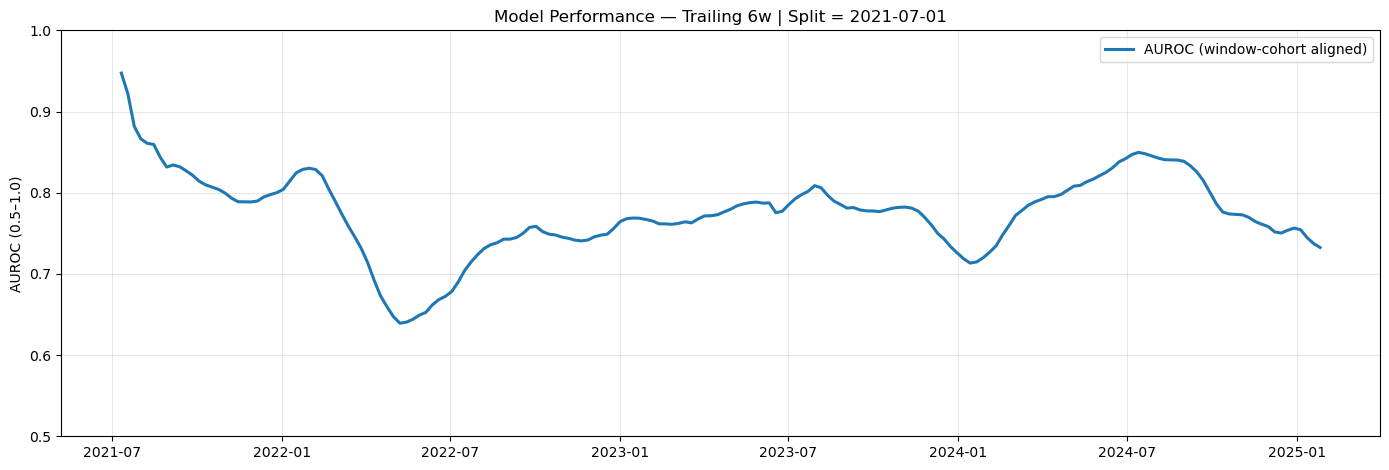

[OK] AUROC PNG → results/tfidf_pca/20210701/auroc_trailing_w6_step1_s0.png


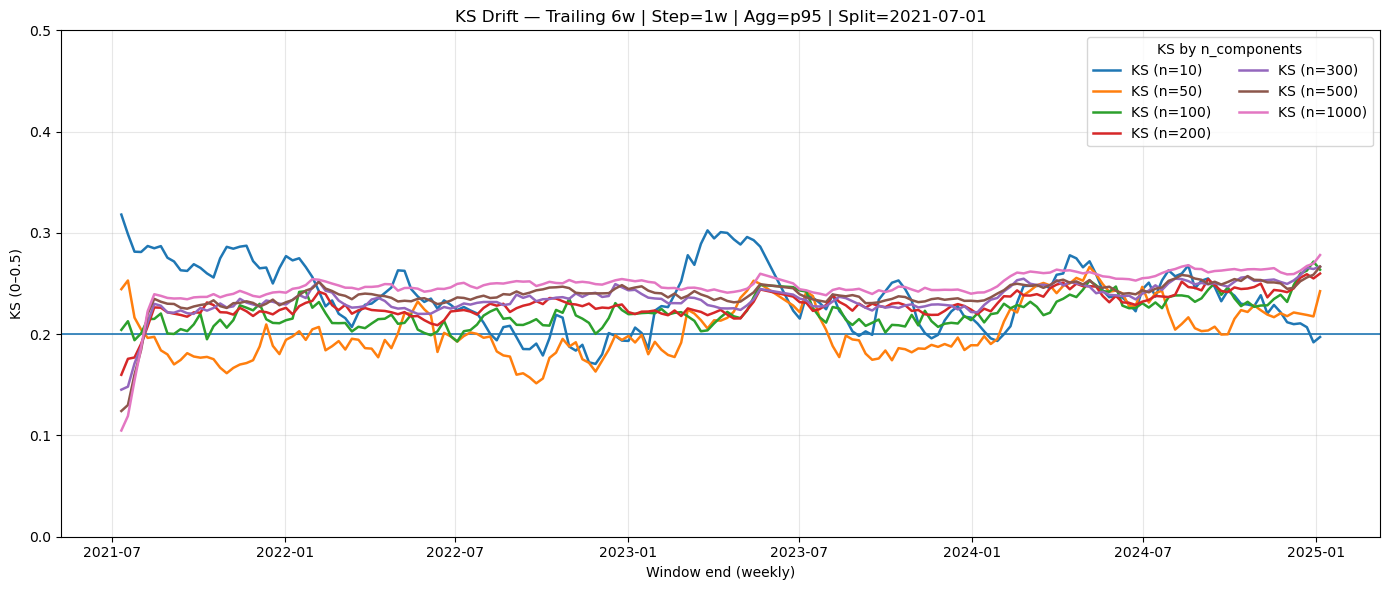

[OK] KS overlay PNG → results/tfidf_pca/20210701/ks_overlay_w6_step1_s0_p95.png


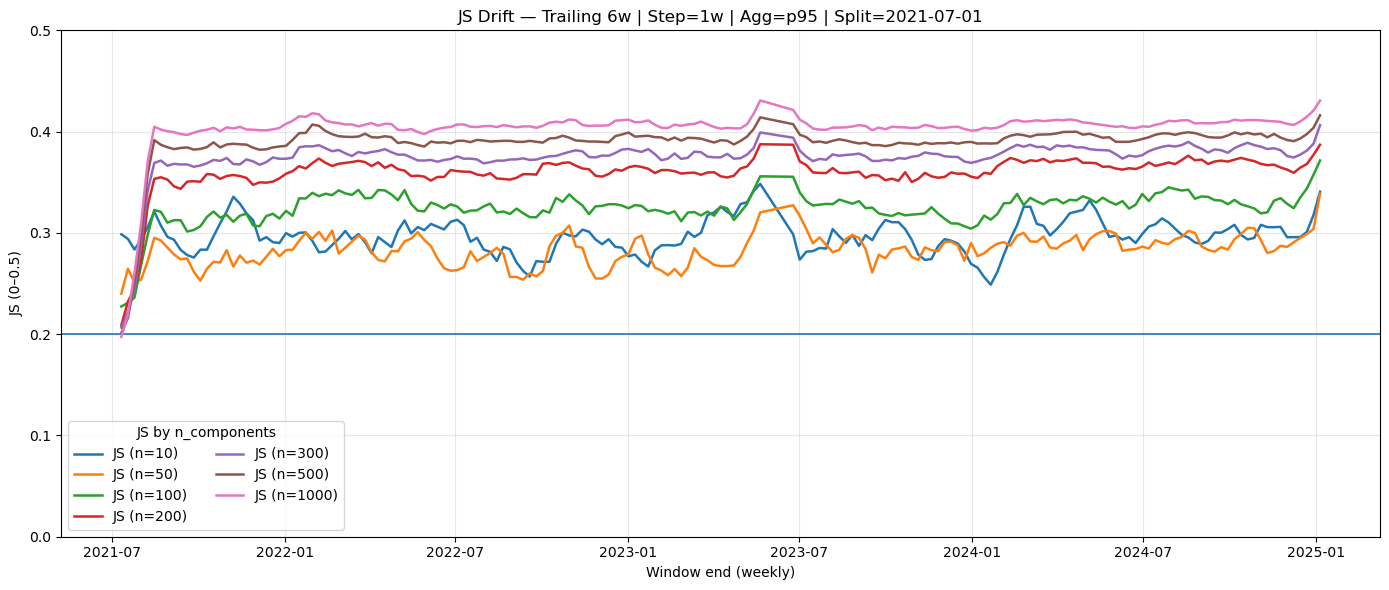

[OK] JS overlay PNG → results/tfidf_pca/20210701/js_overlay_w6_step1_s0_p95.png


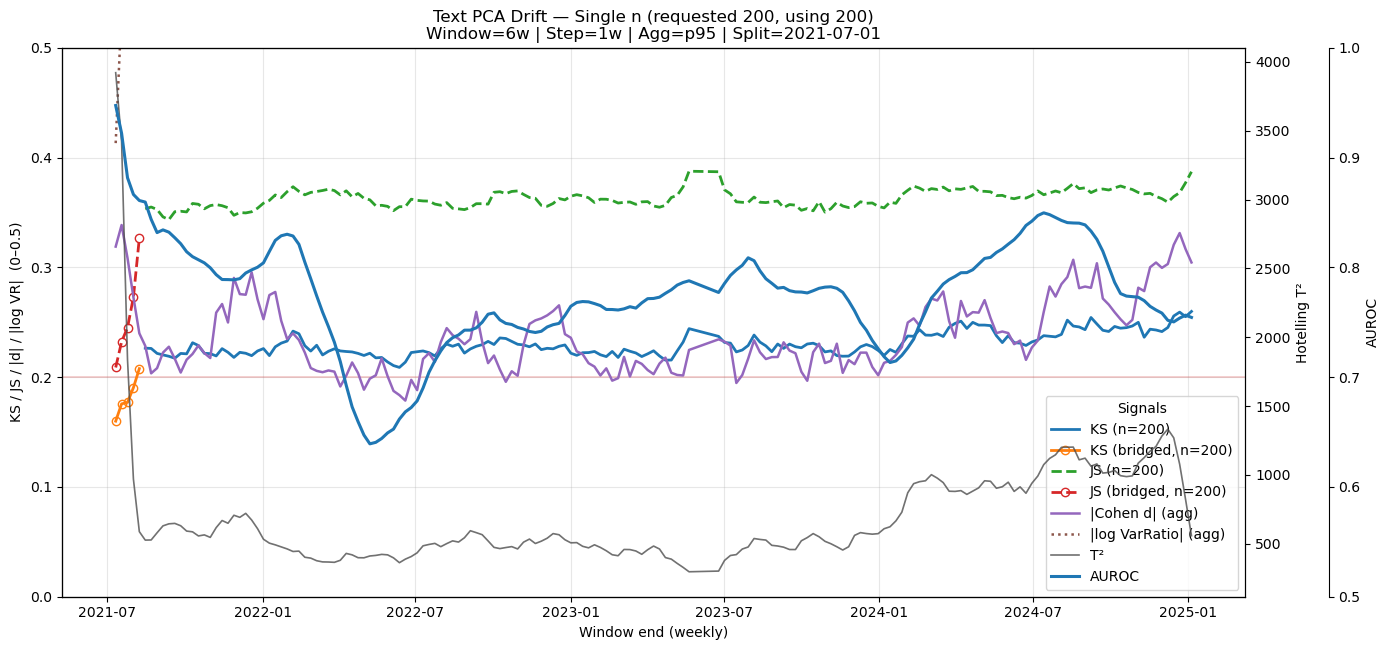

[OK] Single-n KS+JS PNG → results/tfidf_pca/20210701/singleN_n200_w6_step1_s0_p95.png
[WARN] Skipped PCA component inspection: Could not find components in results/tfidf_pca/20210701/ncomp_0200 (looked for svd_components.npz/.npy)
[OK] Summary CSV → results/tfidf_pca/20210701/drift_overlay_summary.csv

=== Static correlations (n = 200) ===
ks_agg_smooth: Pearson=-0.014, Spearman=0.196
js_agg_smooth: Pearson=-0.340, Spearman=0.027
cohen_d_agg: Pearson=0.450, Spearman=0.399

=== Lagged correlations (±6 weeks) ===
    lag_weeks   metric   pearson  spearman  n_pairs
2          -6  COHEN_D  0.220000  0.228970      173
5          -5  COHEN_D  0.235536  0.240605      174
8          -4  COHEN_D  0.260739  0.263059      175
11         -3  COHEN_D  0.301117  0.292338      176
14         -2  COHEN_D  0.354428  0.325393      177
17         -1  COHEN_D  0.412213  0.362773      178
20          0  COHEN_D  0.450367  0.399276      179
23          1  COHEN_D  0.465345  0.435106      178
26          2  

In [1]:
# ============================================================
# Trailing-window TF-IDF+PCA drift (KS/JS) + window-cohort AUROC
# + PCA components inspection (top terms per PC)
#
# Plots (shown inline AND saved):
#   (1) AUROC only
#   (2) KS overlay across n_components (separate figure)
#   (3) JS overlay across n_components (separate figure)
#   (4) KS+JS for a single PCA size (e.g., n=200) + AUROC overlay (ADDED)
# ============================================================

import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import roc_auc_score

# -------------------
# REQUIRED: set these paths
# -------------------
SPLIT_DATE_STR  = "2021-07-01"
SPLIT_DIR       = "results/tfidf_pca/20210701"
PREDICTIONS_CSV = "results/mortality_predictions_holdout.csv"
AUROC_CSV       = "results/mortality_auc_curves_results.csv"

PRED_DT_COL     = "admitdatetime"
PRED_SPLIT_COL  = "split_date"
PRED_Y_COL      = "y_true"
PRED_P_COL      = "y_score"

# -------------------
# Windowing & drift knobs
# -------------------
WINDOW_LENGTH_WEEKS = 6
MOVE_WEEKS          = 1
SMOOTH_K            = 0
MIN_N_WINDOW        = 100
MIN_N_BASELINE      = 100
BINS                = 40
USE_BINNED_KS       = True
AGGREGATION         = "p95"   # "median" | "mean" | "p95"
BASELINE_SUBSAMP    = 20000
ATTN_THRESH         = 0.2

SAVE_PER_RUN_DRIFT_PNG = False
SELECTED_N_FOR_SINGLE_PLOT = 200

# --- Global y-limit for drift metrics (KS/JS) ----------------
DRIFT_YMAX = 0.5   # drift plots scaled to 0–0.5

# ===================
# Helpers
# ===================
def _quantile_bounds(a):
    lo, hi = np.nanpercentile(a, 0.5), np.nanpercentile(a, 99.5)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = np.nanmin(a), np.nanmax(a) + 1e-9
    return float(lo), float(hi)

def _hist_1d(a, edges):
    a = a[np.isfinite(a)]
    if a.size == 0:
        h = np.ones(len(edges)-1, dtype=float); h /= h.sum()
        return h
    h, _ = np.histogram(a, bins=edges, density=True)
    h = h.astype(float) + 1e-12
    h /= h.sum()
    return h

def _cdf_from_hist(h):
    c = np.cumsum(h); s = c[-1] if c.size else 1.0
    return c / (s if s > 0 else 1.0)

def _aggregate(vals, how="median"):
    vals = np.asarray(vals, dtype=float)
    if how == "median": return float(np.median(vals))
    if how == "mean":   return float(np.mean(vals))
    return float(np.percentile(vals, 95))

def _week_ending(ts):
    ts = pd.Timestamp(ts)
    return (ts + pd.offsets.Week(weekday=6)).normalize()  # Sunday week-end

def _weekly_endpoints(start_date, end_date, step_weeks=1):
    start_end = _week_ending(pd.to_datetime(start_date))
    first_ep  = start_end + pd.Timedelta(weeks=1)    # "week 1 after split"
    last_ep   = _week_ending(pd.to_datetime(end_date))
    eps = []
    cur = first_ep
    while cur <= last_ep:
        eps.append(cur)
        cur = cur + pd.Timedelta(weeks=step_weeks)
    return eps

def _indices_in_window(dates, window_end, window_len_weeks):
    right = pd.Timestamp(window_end)
    left  = right - pd.Timedelta(weeks=window_len_weeks)
    mask = (dates > left) & (dates <= right)
    return np.where(mask.to_numpy())[0]

def _parse_ncomp_from_dirname(dirname: str) -> int | None:
    m = re.search(r"ncomp_(\d+)", os.path.basename(dirname))
    return int(m.group(1)) if m else None

# ===================
# Drift computation
# ===================
def eval_drift_trailing_weekly(
    Z_all, dates, split_date, endpoints=None,
    window_length_weeks=12, move_weeks=1, smooth_k=0,
    bins=40, agg="median", use_binned_ks=True,
    min_n_window=200, min_n_baseline=200,
    baseline_subsample=20000, seed=42
):
    rng = np.random.default_rng(seed)
    dts = pd.to_datetime(dates)
    split_ts = pd.to_datetime(split_date)

    base_all_idx = np.where(dts < split_ts)[0]
    if base_all_idx.size == 0:
        return pd.DataFrame(columns=[
            "split_date","window_start","window_end","n_total","n_pre_in_window","n_post_in_window",
            "ks_agg","js_agg","cohen_d_agg","logvar_agg","t2","t2_p",
            "overlap_weeks","ks_agg_smooth","js_agg_smooth"
        ])

    if endpoints is None:
        endpoints = _weekly_endpoints(split_ts, dts.max(), step_weeks=move_weeks)

    rows = []
    for ep in endpoints:
        idx_w = _indices_in_window(dts, ep, window_length_weeks)
        if idx_w.size < min_n_window:
            continue

        n_total = int(idx_w.size)
        n_pre   = int(np.sum(dts.iloc[idx_w] < split_ts))
        n_post  = n_total - n_pre

        # Adjusted baseline to avoid leakage
        if n_pre > 0:
            pre_used = idx_w[dts.iloc[idx_w] < split_ts]
            ref_idx  = np.setdiff1d(base_all_idx, pre_used, assume_unique=False)
        else:
            ref_idx = base_all_idx.copy()

        if ref_idx.size < min_n_baseline:
            continue

        if baseline_subsample and ref_idx.size > baseline_subsample:
            ref_idx = rng.choice(ref_idx, size=baseline_subsample, replace=False)

        A = Z_all[ref_idx, :]   # baseline PC scores
        B = Z_all[idx_w, :]     # current-window PC scores

        n_comp = A.shape[1]
        ks_vals, js_vals = [], []
        d_vals, vr_vals  = [], []

        for j in range(n_comp):
            a = A[:, j]; b = B[:, j]
            # JS/KS via hist/binned CDFs for stability
            lo, hi = _quantile_bounds(a)
            edges  = np.linspace(lo, hi, bins + 1)
            Pa     = _hist_1d(a, edges)
            Pb     = _hist_1d(b, edges)
            js     = float(jensenshannon(Pa, Pb))
            if use_binned_ks:
                ks = float(np.max(np.abs(_cdf_from_hist(Pa) - _cdf_from_hist(Pb))))
            else:
                ks = stats.ks_2samp(a, b, alternative="two-sided", mode="asymp").statistic
            ks_vals.append(ks); js_vals.append(js)

            # Moments in PC space
            d_vals.append(_cohens_d_1d(a, b))
            vr = _var_ratio_1d(a, b)
            # Take log and abs for symmetry around 0
            vr_vals.append(np.abs(np.log(vr)) if np.isfinite(vr) and vr > 0 else np.nan)

        # Aggregations
        ks_agg   = _aggregate_vec(ks_vals, how=agg)
        js_agg   = _aggregate_vec(js_vals, how=agg)
        d_agg    = _aggregate_vec(np.abs(d_vals), how=agg)      # |Cohen's d|
        lvr_agg  = _aggregate_vec(vr_vals, how=agg)             # |log VarRatio|

        # Hotelling's T^2
        t2, t2_p = _hotellings_T2(A, B, ridge_lambda=1e-6)

        rows.append({
            "split_date": split_date,
            "window_start": pd.to_datetime(ep) - pd.Timedelta(weeks=window_length_weeks) + pd.Timedelta(seconds=1),
            "window_end": pd.to_datetime(ep),
            "n_total": n_total,
            "n_pre_in_window": n_pre,
            "n_post_in_window": n_post,
            "ks_agg": ks_agg,
            "js_agg": js_agg,
            "cohen_d_agg": d_agg,
            "logvar_agg": lvr_agg,
            "t2": float(t2),
            "t2_p": float(t2_p),
            "overlap_weeks": int(np.ceil(n_pre / 7.0)) if n_pre > 0 else 0
        })

    out = pd.DataFrame(rows).sort_values("window_end").reset_index(drop=True)

    # Smooth KS/JS only (moments are already aggregates)
    if smooth_k and smooth_k > 1 and not out.empty:
        out["ks_agg_smooth"] = out["ks_agg"].rolling(window=smooth_k, min_periods=1).mean()
        out["js_agg_smooth"] = out["js_agg"].rolling(window=smooth_k, min_periods=1).mean()
    else:
        out["ks_agg_smooth"] = out["ks_agg"]
        out["js_agg_smooth"] = out["js_agg"]

    return out

# ===================
# AUROC helpers
# ===================
# ===== PCA moment monitors (Cohen's d, Var Ratio) + Hotelling T^2 =====
import numpy as np
from scipy import stats

def _cohens_d_1d(x, y):
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    sx2 = np.nanvar(x, ddof=1)
    sy2 = np.nanvar(y, ddof=1)
    denom = (nx + ny - 2)
    if denom <= 0:
        return np.nan
    sp2 = ((nx - 1) * sx2 + (ny - 1) * sy2) / denom
    if not np.isfinite(sp2) or sp2 <= 0:
        return np.nan
    sp = np.sqrt(sp2)
    return (np.nanmean(y) - np.nanmean(x)) / sp  # current vs baseline

def _var_ratio_1d(x, y):
    vx = np.nanvar(x, ddof=1)
    vy = np.nanvar(y, ddof=1)
    if not np.isfinite(vx) or not np.isfinite(vy) or vx <= 0:
        return np.nan
    return vy / vx  # current / baseline

def _aggregate_vec(v, how="median"):
    v = np.asarray(v, dtype=float)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return np.nan
    if how == "mean":
        return float(np.mean(v))
    if how == "median":
        return float(np.median(v))
    return float(np.percentile(v, 95))

def _hotellings_T2(base_pc, cur_pc, ridge_lambda=1e-6):
    """
    Hotelling's T^2 comparing mean(cur_pc) vs mean(base_pc) using baseline covariance.
    Returns (T2, p_value_approx) where p uses chi-square df = k (n_components).
    """
    xb = np.asarray(base_pc, float)
    yc = np.asarray(cur_pc, float)
    mu_b = np.nanmean(xb, axis=0)
    mu_c = np.nanmean(yc, axis=0)
    diff = (mu_c - mu_b)

    Sb = np.cov(xb, rowvar=False)
    if np.ndim(Sb) == 0:  # 1 component edge-case
        Sb = np.array([[Sb]])
    k = Sb.shape[0]
    Sb_reg = Sb + ridge_lambda * np.eye(k)

    try:
        invSb = np.linalg.inv(Sb_reg)
    except np.linalg.LinAlgError:
        invSb = np.linalg.pinv(Sb_reg)

    n_b, n_c = xb.shape[0], yc.shape[0]
    scale = (n_b * n_c) / max(n_b + n_c, 1)
    T2 = float(scale * (diff @ invSb @ diff))
    pval = 1.0 - stats.chi2.cdf(T2, df=k)
    return T2, pval



def aggregate_auroc_weekly_from_csv(auroc_csv: str, split_date: str) -> pd.DataFrame:
    if not os.path.exists(auroc_csv):
        return pd.DataFrame(columns=["period","auroc"])
    a = pd.read_csv(auroc_csv)
    a["admitdatetime"] = pd.to_datetime(a.get("admitdatetime"), errors="coerce")
    a["split_date"]    = pd.to_datetime(a.get("split_date"), errors="coerce")
    mask = (a["split_date"] == pd.to_datetime(split_date)) & a["admitdatetime"].notna()
    a = a.loc[mask, ["admitdatetime","auroc"]].dropna()
    if a.empty:
        return pd.DataFrame(columns=["period","auroc"])
    a["period"] = a["admitdatetime"].apply(_week_ending)
    g = a.groupby("period", as_index=False).agg(auroc=("auroc","mean"))
    return g.sort_values("period")

def compute_window_cohort_auroc_from_preds(
    preds_csv: str,
    split_date_str: str,
    window_length_weeks: int,
    move_weeks: int,
    smooth_k: int,
    dt_col: str = "admitdatetime",
    split_col: str = "split_date",
    y_col: str = "y_true",
    p_col: str = "y_score",
    endpoints: list | None = None
):
    if not os.path.exists(preds_csv):
        raise FileNotFoundError(f"Predictions CSV not found: {preds_csv}")
    df = pd.read_csv(preds_csv)
    for c in [dt_col, split_col, y_col, p_col]:
        if c not in df.columns:
            raise ValueError(f"Missing column '{c}' in {preds_csv}")

    df[dt_col]    = pd.to_datetime(df[dt_col], errors="coerce")
    df[split_col] = pd.to_datetime(df[split_col], errors="coerce")
    mask = (df[split_col] == pd.to_datetime(split_date_str)) & df[dt_col].notna()
    df = df.loc[mask, [dt_col, y_col, p_col]].dropna()
    if df.empty:
        return pd.DataFrame(columns=["window_end","window_start","n","auroc","auroc_smooth"]), []

    if endpoints is None:
        endpoints = _weekly_endpoints(split_date_str, df[dt_col].max(), step_weeks=move_weeks)

    rows = []
    for ep in endpoints:
        idx = _indices_in_window(df[dt_col], ep, window_length_weeks)
        if idx.size == 0:
            continue
        y = df.iloc[idx][y_col].to_numpy()
        p = df.iloc[idx][p_col].to_numpy()
        if len(np.unique(y)) < 2:
            continue  # AUROC undefined when only one class present
        auc = float(roc_auc_score(y, p))
        rows.append({
            "window_end": pd.to_datetime(ep),
            "window_start": pd.to_datetime(ep) - pd.Timedelta(weeks=window_length_weeks) + pd.Timedelta(seconds=1),
            "n": int(idx.size),
            "auroc": auc
        })
    out = pd.DataFrame(rows).sort_values("window_end").reset_index(drop=True)
    out["auroc_smooth"] = out["auroc"].rolling(window=smooth_k, min_periods=1).mean() if smooth_k and smooth_k>1 else out["auroc"]
    return out, endpoints

def compute_window_auroc_fallback_from_weekly(
    auroc_csv: str,
    split_date_str: str,
    window_length_weeks: int,
    move_weeks: int,
    smooth_k: int,
    endpoints: list | None = None
):
    weekly = aggregate_auroc_weekly_from_csv(auroc_csv, split_date_str)
    if weekly.empty:
        return pd.DataFrame(columns=["window_end","window_start","n","auroc","auroc_smooth"]), []

    if endpoints is None:
        endpoints = _weekly_endpoints(split_date_str, weekly["period"].max(), step_weeks=move_weeks)

    rows = []
    for ep in endpoints:
        left = pd.Timestamp(ep) - pd.Timedelta(weeks=window_length_weeks)
        mask = (weekly["period"] > left) & (weekly["period"] <= pd.Timestamp(ep))
        w = weekly.loc[mask]
        if w.empty:
            continue
        auc = float(w["auroc"].mean())
        rows.append({
            "window_end": pd.to_datetime(ep),
            "window_start": pd.to_datetime(ep) - pd.Timedelta(weeks=window_length_weeks) + pd.Timedelta(seconds=1),
            "n": int(len(w)),
            "auroc": auc
        })
    out = pd.DataFrame(rows).sort_values("window_end").reset_index(drop=True)
    out["auroc_smooth"] = out["auroc"].rolling(window=smooth_k, min_periods=1).mean() if smooth_k and smooth_k>1 else out["auroc"]
    return out, endpoints

def get_trailing_auroc_series(
    preds_csv: str,
    auroc_csv: str,
    split_date_str: str,
    window_length_weeks: int,
    move_weeks: int,
    smooth_k: int,
    endpoints: list | None = None,
    dt_col: str = "admitdatetime",
    split_col: str = "split_date",
    y_col: str = "y_true",
    p_col: str = "y_score"
):
    try:
        return compute_window_cohort_auroc_from_preds(
            preds_csv, split_date_str, window_length_weeks, move_weeks, smooth_k,
            dt_col, split_col, y_col, p_col, endpoints
        )
    except Exception as e:
        print(f"[INFO] Falling back to trailing mean of weekly AUROC: {e}")
        return compute_window_auroc_fallback_from_weekly(
            auroc_csv, split_date_str, window_length_weeks, move_weeks, smooth_k, endpoints
        )

# ===================
# Batch drift over ncomp_* and plotting
# ===================
def load_dates_for_run(pca_run_dir: str, split_dir: str) -> pd.Series:
    meta_here   = os.path.join(pca_run_dir, "metadata.csv")
    meta_parent = os.path.join(split_dir, "metadata.csv")
    meta_csv = os.path_or = meta_here if os.path.exists(meta_here) else meta_parent
    if not os.path.exists(meta_csv):
        raise FileNotFoundError(f"metadata.csv not found in {pca_run_dir} or {split_dir}")
    meta = pd.read_csv(meta_csv)
    return pd.to_datetime(meta["admitdatetime"])

def compute_and_save_drift_for_run(
    pca_run_dir: str,
    split_dir: str,
    split_date_str: str,
    endpoints: list,
    window_length_weeks: int,
    move_weeks: int,
    smooth_k: int,
    min_n_window: int,
    min_n_baseline: int,
    bins: int,
    use_binned_ks: bool,
    aggregation: str,
    baseline_subsample: int | None
) -> pd.DataFrame:
    z_path = os.path.join(pca_run_dir, "Z_all.npz")
    if not os.path.exists(z_path):
        raise FileNotFoundError(f"Z_all.npz not found in {pca_run_dir}")
    dates = load_dates_for_run(pca_run_dir, split_dir)
    Z_all = np.load(z_path)["Z_all"]

    drift_df = eval_drift_trailing_weekly(
        Z_all, dates, split_date=split_date_str, endpoints=endpoints,
        window_length_weeks=window_length_weeks, move_weeks=move_weeks, smooth_k=smooth_k,
        bins=bins, agg=aggregation, use_binned_ks=use_binned_ks,
        min_n_window=min_n_window, min_n_baseline=min_n_baseline,
        baseline_subsample=baseline_subsample
    )

    tag = f"w{window_length_weeks}_step{move_weeks}_s{smooth_k}_{aggregation}"
    drift_csv = os.path.join(pca_run_dir, f"tfidf_pca_drift_{tag}.csv")
    drift_df.to_csv(drift_csv, index=False)
    print(f"[OK] Drift saved → {drift_csv}")

    if SAVE_PER_RUN_DRIFT_PNG:
        ncomp = _parse_ncomp_from_dirname(pca_run_dir) or drift_df.shape[1]
        plt.figure(figsize=(14, 6))
        plt.axhline(ATTN_THRESH, linewidth=1.2)
        plt.plot(drift_df["window_end"], drift_df["ks_agg_smooth"], linewidth=1.8, label=f"KS (n={ncomp})")
        plt.plot(drift_df["window_end"], drift_df["js_agg_smooth"], linewidth=1.8, linestyle="--", label=f"JS (n={ncomp})")
        plt.ylim(0.0, DRIFT_YMAX)
        plt.ylabel(f"KS/JS (0–{DRIFT_YMAX:g})")
        plt.xlabel("Window end (weekly)")
        plt.title(f"Text PCA Drift — n={ncomp} | Window={window_length_weeks}w Step={move_weeks}w | Split={split_date_str}")
        plt.grid(True, alpha=0.3); plt.legend(loc="best"); plt.tight_layout()
        drift_png = os.path.join(pca_run_dir, f"drift_weekly_{tag}.png")
        plt.savefig(drift_png, dpi=160); plt.show(); plt.close()
        print(f"[OK] Drift PNG → {drift_png}")

    # Manifest
    manifest = {
        "run_dir": pca_run_dir,
        "split_date": split_date_str,
        "window_length_weeks": window_length_weeks,
        "move_weeks": move_weeks,
        "smooth_k": smooth_k,
        "aggregation": aggregation,
        "min_n_window": min_n_window,
        "min_n_baseline": min_n_baseline,
        "bins": bins,
        "use_binned_ks": use_binned_ks,
        "baseline_subsample": baseline_subsample,
        "drift_csv": drift_csv
    }
    with open(os.path.join(pca_run_dir, f"drift_manifest_{tag}.json"), "w") as f:
        json.dump(manifest, f, indent=2)

    return drift_df

def plot_single_auroc(auroc_df: pd.DataFrame, split_date_str: str, window_length_weeks: int, out_png: str | None = None):
    plt.figure(figsize=(14, 4.8))
    if not auroc_df.empty:
        plt.plot(auroc_df["window_end"], auroc_df["auroc_smooth"], linewidth=2.2, label="AUROC (window-cohort aligned)")
    else:
        plt.text(0.5, 0.5, "No AUROC rows for this split", ha="center", va="center", transform=plt.gca().transAxes)
    plt.ylim(0.5, 1.0)
    plt.ylabel("AUROC (0.5–1.0)")
    plt.title(f"Model Performance — Trailing {window_length_weeks}w | Split = {split_date_str}")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=160)
    plt.show(); plt.close()

def plot_multi_ks_overlay(drift_by_n: dict, split_date_str: str, window_length_weeks: int, move_weeks: int, aggregation: str, out_png: str | None = None):
    plt.figure(figsize=(14, 6.0))
    plt.axhline(ATTN_THRESH, linewidth=1.2)
    for ncomp in sorted(drift_by_n.keys()):
        ddf = drift_by_n[ncomp]
        if ddf.empty: continue
        plt.plot(ddf["window_end"], ddf["ks_agg_smooth"], linewidth=1.8, label=f"KS (n={ncomp})")
    plt.ylim(0.0, DRIFT_YMAX)
    plt.ylabel(f"KS (0–{DRIFT_YMAX:g})")
    plt.xlabel("Window end (weekly)")
    plt.title(f"KS Drift — Trailing {window_length_weeks}w | Step={move_weeks}w | Agg={aggregation} | Split={split_date_str}")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, title="KS by n_components", loc="best")
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=160)
    plt.show(); plt.close()

def plot_multi_js_overlay(drift_by_n: dict, split_date_str: str, window_length_weeks: int, move_weeks: int, aggregation: str, out_png: str | None = None):
    plt.figure(figsize=(14, 6.0))
    plt.axhline(ATTN_THRESH, linewidth=1.2)
    for ncomp in sorted(drift_by_n.keys()):
        ddf = drift_by_n[ncomp]
        if ddf.empty: continue
        plt.plot(ddf["window_end"], ddf["js_agg_smooth"], linewidth=1.8, label=f"JS (n={ncomp})")
    plt.ylim(0.0, DRIFT_YMAX)
    plt.ylabel(f"JS (0–{DRIFT_YMAX:g})")
    plt.xlabel("Window end (weekly)")
    plt.title(f"JS Drift — Trailing {window_length_weeks}w | Step={move_weeks}w | Agg={aggregation} | Split={split_date_str}")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, title="JS by n_components", loc="best")
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=160)
    plt.show(); plt.close()

# ---------- Single-n KS+JS figure with AUROC overlay (ADDED) ----------
def _nearest_available_n(requested_n: int, keys: list[int]) -> int:
    if requested_n in keys: return requested_n
    keys_sorted = sorted(keys)
    diffs = [(abs(k - requested_n), k) for k in keys_sorted]
    diffs.sort()
    return diffs[0][1] if diffs else requested_n

def plot_single_n_ks_js(drift_by_n: dict, split_date_str: str, window_length_weeks: int,
                         move_weeks: int, aggregation: str, requested_n: int,
                         auroc_df: pd.DataFrame | None = None,
                         out_png: str | None = None):
    if not drift_by_n:
        print("[WARN] No drift data available for single-n plot."); return
    chosen_n = _nearest_available_n(requested_n, list(drift_by_n.keys()))
    ddf = drift_by_n[chosen_n]
    if ddf.empty:
        print(f"[WARN] Drift dataframe empty for n={chosen_n}."); return

    bridged = ddf["n_pre_in_window"] > 0
    pure    = ~bridged

    fig, ax = plt.subplots(figsize=(14, 6.6))
    ax.axhline(ATTN_THRESH, linewidth=1.2, color="tab:red", alpha=0.25)

    # KS
    ax.plot(ddf.loc[pure, "window_end"], ddf.loc[pure, "ks_agg_smooth"],
            linewidth=2.0, label=f"KS (n={chosen_n})")
    ax.plot(ddf.loc[bridged, "window_end"], ddf.loc[bridged, "ks_agg_smooth"],
            linewidth=2.0, marker='o', fillstyle='none', linestyle='-', label=f"KS (bridged, n={chosen_n})")

    # JS
    ax.plot(ddf.loc[pure, "window_end"], ddf.loc[pure, "js_agg_smooth"],
            linewidth=2.0, linestyle="--", label=f"JS (n={chosen_n})")
    ax.plot(ddf.loc[bridged, "window_end"], ddf.loc[bridged, "js_agg_smooth"],
            linewidth=2.0, linestyle="--", marker='o', fillstyle='none', label=f"JS (bridged, n={chosen_n})")

    # PCA moment monitors on left y-axis (same 0–0.5 scale)
    ax.plot(ddf["window_end"], ddf["cohen_d_agg"], linewidth=1.8, label="|Cohen d| (agg)")
    ax.plot(ddf["window_end"], ddf["logvar_agg"], linewidth=1.8, linestyle=":", label="|log VarRatio| (agg)")

    # Left axis formatting
    ax.set_ylim(0.0, DRIFT_YMAX)
    ax.set_ylabel(f"KS / JS / |d| / |log VR|  (0–{DRIFT_YMAX:g})")
    ax.set_xlabel("Window end (weekly)")
    ax.grid(True, alpha=0.3)

    # Right axis #1: Hotelling T²
    ax2 = ax.twinx()
    if "t2" in ddf.columns:
        ax2.plot(ddf["window_end"], ddf["t2"], color="0.3", linewidth=1.2, alpha=0.8, label="T²")
        ax2.set_ylabel("Hotelling T²")

    # Right axis #2 (offset): AUROC overlay
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    if auroc_df is not None and not auroc_df.empty:
        perf_merge = pd.merge(
            auroc_df[["window_end","auroc_smooth"]],
            ddf[["window_end"]],
            on="window_end",
            how="inner"
        ).dropna()
        if not perf_merge.empty:
            ax3.plot(perf_merge["window_end"], perf_merge["auroc_smooth"],
                     linewidth=2.2, label="AUROC", linestyle="-")
            ax3.set_ylim(0.5, 1.0)
            ax3.set_ylabel("AUROC")

    # Combined legend
    lines_left, labels_left = ax.get_legend_handles_labels()
    lines_r1, labels_r1     = ax2.get_legend_handles_labels()
    lines_r2, labels_r2     = ax3.get_legend_handles_labels()
    ax.legend(lines_left + lines_r1 + lines_r2, labels_left + labels_r1 + labels_r2,
              title="Signals", loc="best")

    ax.set_title(
        f"Text PCA Drift — Single n (requested {requested_n}, using {chosen_n})\n"
        f"Window={window_length_weeks}w | Step={move_weeks}w | Agg={aggregation} | Split={split_date_str}"
    )
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=160)
    plt.show(); plt.close()



# =========================
# NEW: PCA COMPONENTS INSPECTION
# =========================
def _load_components_matrix(run_dir: str):
    """
    Returns (components, evr) where:
      components: shape (n_components, n_terms) – rows are PCs
      evr: None or shape (n_components,)
    """
    # Try .npz first
    npz_path = os.path.join(run_dir, "svd_components.npz")
    if os.path.exists(npz_path):
        npz = np.load(npz_path)
        comps = None
        for k in ["components", "Vt", "svd_components"]:
            if k in npz:
                comps = np.array(npz[k])
                break
        if comps is None:
            raise FileNotFoundError(f"No components array in {npz_path} (expected keys: components/Vt/svd_components)")
        evr = None
        for k in ["explained_variance_ratio", "evr", "expl_var_ratio"]:
            if k in npz:
                evr = np.array(npz[k])
                break
        return comps, evr

    # Then .npy
    npy_path = os.path.join(run_dir, "svd_components.npy")
    if os.path.exists(npy_path):
        comps = np.load(npy_path)
        evr = None
        for fname in ["explained_variance_ratio.npy", "evr.npy"]:
            p = os.path.join(run_dir, fname)
            if os.path.exists(p):
                evr = np.load(p)
                break
        return comps, evr

    raise FileNotFoundError(f"Could not find components in {run_dir} (looked for svd_components.npz/.npy)")

def _load_terms_list(run_dir: str, split_dir: str, expected_dim: int | None = None):
    """
    Returns a list of terms of length n_terms aligned with TF-IDF columns.
    Looks in run_dir first, then split_dir.
    """
    candidates = [
        os.path.join(run_dir,  "terms.npy"),
        os.path.join(run_dir,  "terms.txt"),
        os.path.join(split_dir,"terms.npy"),
        os.path.join(split_dir,"terms.txt"),
    ]
    for p in candidates:
        if os.path.exists(p):
            if p.endswith(".npy"):
                terms = np.load(p, allow_pickle=True).tolist()
            else:
                with open(p, "r", encoding="utf-8") as f:
                    terms = [line.strip() for line in f if line.strip()]
            if expected_dim is not None and len(terms) != expected_dim:
                print(f"[WARN] terms length ({len(terms)}) != expected ({expected_dim})")
            return terms

    # Try vocabulary JSONs (term -> index)
    vocab_candidates = [
        os.path.join(run_dir,  "tfidf_vocabulary.json"),
        os.path.join(run_dir,  "vectorizer_vocabulary.json"),
        os.path.join(run_dir,  "vocab.json"),
        os.path.join(split_dir,"tfidf_vocabulary.json"),
        os.path.join(split_dir,"vectorizer_vocabulary.json"),
        os.path.join(split_dir,"vocab.json"),
    ]
    for p in vocab_candidates:
        if os.path.exists(p):
            with open(p, "r", encoding="utf-8") as f:
                vocab = json.load(f)  # dict: term -> index
            if not isinstance(vocab, dict):
                raise ValueError(f"Vocabulary in {p} is not a dict.")
            n_terms = (max(vocab.values()) + 1) if vocab else 0
            terms = [None] * n_terms
            for t, idx in vocab.items():
                if 0 <= idx < n_terms:
                    terms[idx] = t
            terms = [t if t is not None else f"<unk_{i}>" for i, t in enumerate(terms)]
            if expected_dim is not None and len(terms) != expected_dim:
                print(f"[WARN] vocab-inferred terms length ({len(terms)}) != expected ({expected_dim})")
            return terms

    raise FileNotFoundError(
        f"No terms/ vocabulary found in {run_dir} or {split_dir}. "
        f"Expected one of: terms.npy/terms.txt or *vocabulary*.json"
    )

def pca_top_terms_table(run_dir: str, split_dir: str, topn: int = 15, pcs: list[int] | None = None) -> pd.DataFrame:
    """
    Build a table of top positive and negative terms for selected PCs.
    Returns a DataFrame: ['pc','rank','sign','term','loading','explained_var_ratio']
    """
    comps, evr = _load_components_matrix(run_dir)
    n_comp, n_terms = comps.shape
    terms = _load_terms_list(run_dir, split_dir, expected_dim=n_terms)

    if pcs is None:
        pcs = list(range(min(5, n_comp)))  # default: first 5 components

    rows = []
    for pc in pcs:
        if pc < 0 or pc >= n_comp:
            print(f"[WARN] PC index {pc} out of range [0,{n_comp-1}] — skipping.")
            continue
        w = comps[pc, :]
        order_pos = np.argsort(-w)    # largest positive
        order_neg = np.argsort(w)     # most negative
        evr_val  = float(evr[pc]) if evr is not None and pc < len(evr) else np.nan

        for r, idx in enumerate(order_pos[:topn], start=1):
            rows.append({
                "pc": pc, "rank": r, "sign": "+",
                "term": terms[idx], "loading": float(w[idx]),
                "explained_var_ratio": evr_val
            })
        for r, idx in enumerate(order_neg[:topn], start=1):
            rows.append({
                "pc": pc, "rank": r, "sign": "−",
                "term": terms[idx], "loading": float(w[idx]),
                "explained_var_ratio": evr_val
            })

    df = pd.DataFrame(rows, columns=["pc","rank","sign","term","loading","explained_var_ratio"])
    return df.sort_values(["pc","sign","rank"])

# ===================
# DRIVER
# ===================
def main():
    # 1) AUROC & endpoints
    auroc_df, endpoints = get_trailing_auroc_series(
        preds_csv=PREDICTIONS_CSV,
        auroc_csv=AUROC_CSV,
        split_date_str=SPLIT_DATE_STR,
        window_length_weeks=WINDOW_LENGTH_WEEKS,
        move_weeks=MOVE_WEEKS,
        smooth_k=SMOOTH_K,
        endpoints=None,
        dt_col=PRED_DT_COL,
        split_col=PRED_SPLIT_COL,
        y_col=PRED_Y_COL,
        p_col=PRED_P_COL
    )

    # 2) Drift for each ncomp_*
    if not os.path.isdir(SPLIT_DIR):
        raise NotADirectoryError(f"Split dir not found: {SPLIT_DIR}")

    ncomp_dirs = [os.path.join(SPLIT_DIR, d) for d in os.listdir(SPLIT_DIR)
                  if os.path.isdir(os.path.join(SPLIT_DIR, d)) and re.match(r"ncomp_\d+", d)]
    ncomp_dirs = sorted(ncomp_dirs, key=lambda p: _parse_ncomp_from_dirname(p) or 0)

    drift_by_n = {}
    for run_dir in ncomp_dirs:
        try:
            drift_df = compute_and_save_drift_for_run(
                pca_run_dir=run_dir,
                split_dir=SPLIT_DIR,
                split_date_str=SPLIT_DATE_STR,
                endpoints=endpoints,
                window_length_weeks=WINDOW_LENGTH_WEEKS,
                move_weeks=MOVE_WEEKS,
                smooth_k=SMOOTH_K,
                min_n_window=MIN_N_WINDOW,
                min_n_baseline=MIN_N_BASELINE,
                bins=BINS,
                use_binned_ks=USE_BINNED_KS,
                aggregation=AGGREGATION,
                baseline_subsample=BASELINE_SUBSAMP
            )
            ncomp = _parse_ncomp_from_dirname(run_dir) or drift_df.shape[1]
            drift_by_n[ncomp] = drift_df
        except Exception as e:
            print(f"[SKIP] {run_dir}: {e}")

    # 3) Plots
    auroc_png = os.path.join(SPLIT_DIR, f"auroc_trailing_w{WINDOW_LENGTH_WEEKS}_step{MOVE_WEEKS}_s{SMOOTH_K}.png")
    plot_single_auroc(auroc_df, SPLIT_DATE_STR, WINDOW_LENGTH_WEEKS, out_png=auroc_png)
    print(f"[OK] AUROC PNG → {auroc_png}")

    ks_png = os.path.join(SPLIT_DIR, f"ks_overlay_w{WINDOW_LENGTH_WEEKS}_step{MOVE_WEEKS}_s{SMOOTH_K}_{AGGREGATION}.png")
    plot_multi_ks_overlay(drift_by_n, SPLIT_DATE_STR, WINDOW_LENGTH_WEEKS, MOVE_WEEKS, AGGREGATION, out_png=ks_png)
    print(f"[OK] KS overlay PNG → {ks_png}")

    js_png = os.path.join(SPLIT_DIR, f"js_overlay_w{WINDOW_LENGTH_WEEKS}_step{MOVE_WEEKS}_s{SMOOTH_K}_{AGGREGATION}.png")
    plot_multi_js_overlay(drift_by_n, SPLIT_DATE_STR, WINDOW_LENGTH_WEEKS, MOVE_WEEKS, AGGREGATION, out_png=js_png)
    print(f"[OK] JS overlay PNG → {js_png}")

    single_png = os.path.join(
        SPLIT_DIR,
        f"singleN_n{SELECTED_N_FOR_SINGLE_PLOT}_w{WINDOW_LENGTH_WEEKS}_step{MOVE_WEEKS}_s{SMOOTH_K}_{AGGREGATION}.png"
    )
    plot_single_n_ks_js(
        drift_by_n, SPLIT_DATE_STR, WINDOW_LENGTH_WEEKS, MOVE_WEEKS,
        AGGREGATION, SELECTED_N_FOR_SINGLE_PLOT,
        auroc_df=auroc_df,
        out_png=single_png
    )
    print(f"[OK] Single-n KS+JS PNG → {single_png}")

    # 3b) (NEW) Inspect PCA components for the selected n (for interpretability)
    try:
        chosen_n_for_terms = _nearest_available_n(SELECTED_N_FOR_SINGLE_PLOT, list(drift_by_n.keys()))
        run_dir_for_terms  = os.path.join(SPLIT_DIR, f"ncomp_{chosen_n_for_terms:04d}")

        TOPN_TERMS = 15
        PCS_TO_SHOW = [0, 1, 2]  # change as needed
        terms_df = pca_top_terms_table(run_dir_for_terms, SPLIT_DIR, topn=TOPN_TERMS, pcs=PCS_TO_SHOW)

        if not terms_df.empty:
            preview = terms_df[(terms_df["pc"].isin(PCS_TO_SHOW)) & (terms_df["sign"] == "+")].copy()
            print("\n=== PCA components — top positive terms per PC ===")
            for pc in PCS_TO_SHOW:
                sub = preview[preview["pc"] == pc].head(TOPN_TERMS)
                if sub.empty: 
                    continue
                evr_val = sub["explained_var_ratio"].iloc[0]
                print(f"\nPC {pc} (EVR={evr_val if pd.notna(evr_val) else float('nan'):.4f}):")
                for _, row in sub.iterrows():
                    print(f"  {row['rank']:>2d}. {row['term']}  (loading={row['loading']:.4f})")

        out_terms_csv = os.path.join(run_dir_for_terms, f"pca_top_terms_pc{','.join(map(str,PCS_TO_SHOW))}_top{TOPN_TERMS}.csv")
        terms_df.to_csv(out_terms_csv, index=False)
        print(f"[OK] PCA top-terms CSV → {out_terms_csv}")

    except Exception as e:
        print(f"[WARN] Skipped PCA component inspection: {e}")

    # 4) Summary manifest
    summary = []
    for ncomp, df in drift_by_n.items():
        tag = f"w{WINDOW_LENGTH_WEEKS}_step{MOVE_WEEKS}_s{SMOOTH_K}_{AGGREGATION}"
        summary.append({
            "n_components": ncomp,
            "drift_csv": os.path.join(SPLIT_DIR, f"ncomp_{ncomp:04d}", f"tfidf_pca_drift_{tag}.csv")
        })
    pd.DataFrame(summary).sort_values("n_components").to_csv(
        os.path.join(SPLIT_DIR, "drift_overlay_summary.csv"), index=False
    )
    print("[OK] Summary CSV →", os.path.join(SPLIT_DIR, "drift_overlay_summary.csv"))

    # ------------------------------------------------------------
    # Correlation analysis between AUROC and KS/JS drift (+ Cohen's d) for n≈200 (ADDED)
    # ------------------------------------------------------------
    if not auroc_df.empty and drift_by_n:
        chosen_n = _nearest_available_n(200, list(drift_by_n.keys()))
        drift_df = drift_by_n.get(chosen_n, pd.DataFrame())

        if not drift_df.empty:
            merged = pd.merge(
                drift_df[["window_end","ks_agg_smooth","js_agg_smooth","cohen_d_agg"]],
                auroc_df[["window_end","auroc_smooth"]],
                on="window_end",
                how="inner"
            ).dropna()

            if not merged.empty:
                print("\n=== Static correlations (n = {}) ===".format(chosen_n))
                for metric in ["ks_agg_smooth","js_agg_smooth","cohen_d_agg"]:
                    pear = merged[metric].corr(merged["auroc_smooth"], method="pearson")
                    spear = merged[metric].corr(merged["auroc_smooth"], method="spearman")
                    print(f"{metric}: Pearson={pear:.3f}, Spearman={spear:.3f}")

                print("\n=== Lagged correlations (±6 weeks) ===")
                results = []
                max_lag = 6
                for lag in range(-max_lag, max_lag+1):
                    tmp = merged.copy()
                    # Positive lag => drift leads AUROC
                    tmp["auroc_shifted"] = tmp["auroc_smooth"].shift(-lag)
                    tmp = tmp.dropna()
                    for metric in ["ks_agg_smooth","js_agg_smooth","cohen_d_agg"]:
                        pear = tmp[metric].corr(tmp["auroc_shifted"], method="pearson")
                        spear = tmp[metric].corr(tmp["auroc_shifted"], method="spearman")
                        results.append({
                            "lag_weeks": lag,
                            "metric": metric.replace("_agg_smooth","").replace("_agg","").upper(),
                            "pearson": float(pear) if pd.notna(pear) else None,
                            "spearman": float(spear) if pd.notna(spear) else None,
                            "n_pairs": int(len(tmp))
                        })

                corr_df = pd.DataFrame(results).sort_values(["metric","lag_weeks"])
                print(corr_df)

                out_csv = os.path.join(SPLIT_DIR, "drift_auroc_correlations.csv")
                corr_df.to_csv(out_csv, index=False)
                print(f"[OK] Saved correlation table → {out_csv}")
            else:
                print("[WARN] No overlapping weeks between drift and AUROC after merge.")
        else:
            print("[WARN] Drift dataframe empty for chosen n.")
    else:
        print("[WARN] Missing AUROC series or drift_by_n dict; cannot compute correlations.")

# Run
if __name__ == "__main__":
    main()



